In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os, sys
from matplotlib import pyplot as plt
from glob import glob

from helpers import extract_day_night_counts, extract_frp_day_night_annual, customized_box_plot
from functools import partial
import multiprocessing as mp
import time


In [2]:
fire_pts_folders = !ls -d ../modis_fire_points/*
shp_files = [glob(folder + '/*.shp')[0] for folder in fire_pts_folders]
dbf_files = [glob(folder + '/*.dbf')[0] for folder in fire_pts_folders]

In [3]:
t0 = time.time()
num_cpu = mp.cpu_count() - 2
num_cpu = 3
pool = mp.Pool(processes=num_cpu)

# extract day night counts
#a = pool.map(partial(extract_day_night_counts, conf=50), shp_files)

# extract FRP values for day night, above 50% confidence and FRP > 0
a = pool.map(partial(extract_frp_day_night_annual, conf=50), dbf_files)


pool.close()
pool.join()
t1 = time.time()

print_time = (t1-t0)/60
print('time: {} minutes'.format(print_time))

time: 7.599677654107412 minutes


In [4]:
import pickle
with open('mp_result_frp_annual_day_night_minmax.pickle', 'wb') as f:
    pickle.dump(a, f)

In [5]:
df = pd.DataFrame(a).sort_values('years')
df

,day_frp_25,day_frp_5,day_frp_75,day_frp_95,day_frp_max,day_frp_mean,day_frp_median,day_frp_min,day_frp_std,night_frp_25,night_frp_5,night_frp_75,night_frp_95,night_frp_max,night_frp_mean,night_frp_median,night_frp_min,night_frp_std,years
0,13.9,7.5,51.4,164.300,6381.0,50.547634,25.1,2.6,99.450640,10.6,6.0,42.1,158.4,3876.2,46.349981,19.3,3.4,108.523686,2000
1,13.4,7.3,49.7,163.700,8767.1,50.311356,24.2,2.2,106.978943,10.4,6.0,37.7,127.9,12854.0,41.156437,18.3,2.6,110.705221,2001
2,14.5,7.7,54.7,186.800,10453.7,56.801434,26.5,2.4,124.955690,10.8,6.1,39.5,134.4,11488.0,42.682402,19.3,2.9,112.739555,2002
3,14.3,7.7,52.7,172.600,12414.7,53.486114,25.8,2.3,116.697564,10.9,6.2,38.0,122.9,10255.9,40.023807,19.0,3.0,100.033940,2003
4,14.2,7.6,52.1,173.400,13290.9,53.606325,25.6,2.1,119.035420,10.4,6.1,36.5,117.4,10851.0,38.251737,18.1,3.0,96.669523,2004
5,14.0,7.6,50.9,166.300,13246.7,51.536194,25.2,2.3,109.536948,10.2,5.9,35.7,112.5,8957.2,35.863626,17.8,3.0,81.352629,2005
6,14.0,7.6,51.1,167.600,11777.0,52.013101,25.2,2.4,111.674361,10.5,6.1,36.9,118.0,11386.2,37.866385,18.3,2.3,91.516085,2006
7,14.1,7.6,51.8,171.800,11499.6,52.877959,25.4,2.2,113.650763,10.3,6.1,36.6,121.1,5569.0,38.748053,17.9,2.7,93.576896,2007
8,13.8,7.5,49.7,158.800,9408.5,49.240665,24.6,2.3,98.945834,10.5,6.2,36.1,113.4,10542.4,36.727430,18.1,3.0,88.744709,2008
9,13.7,7.4,49.1,157.300,7828.2,48.812078,24.4,2.4,99.068283,10.2,6.0,34.7,110.9,10170.0,36.235085,17.6,1.8,93.083597,2009


In [47]:
## save the dataframe to a csv
df.to_csv('modis_frp_daynight_summary_percentiles.csv')

## process result

In [8]:
year = df.years

frp_day_mean = df.day_frp_mean
frp_day_median = df.day_frp_median
frp_day_std = df.day_frp_std
frp_day_min = df.day_frp_min
frp_day_max = df.day_frp_max
frp_day_75 = df.day_frp_75
frp_day_25 = df.day_frp_25
frp_day_5 = df.day_frp_5
frp_day_95 = df.day_frp_95

frp_night_mean = df.night_frp_mean
frp_night_median = df.night_frp_median
frp_night_std = df.night_frp_std
frp_night_min = df.night_frp_min
frp_night_max = df.night_frp_max
frp_night_75 = df.night_frp_75
frp_night_25 = df.night_frp_25
frp_night_5 = df.night_frp_5
frp_night_95 = df.night_frp_95

In [45]:
def customized_box_plot(percentiles, axes, redraw = True, *args, **kwargs):
    """
    Generates a customized boxplot based on the given percentile values
    """

    n_box=percentiles.shape[0]
    box_plot = axes.boxplot([[-9, -4, 2, 4, 9],]*n_box, *args, **kwargs) 
    # Creates len(percentiles) no of box plots

    min_y, max_y = float('inf'), -float('inf')

    fliers_xy=None
    for box_no, (q1_start, 
                 q2_start,
                 q3_start,
                 q4_start,
                 q4_end) in enumerate(percentiles):

        # Lower cap
        box_plot['caps'][2*box_no].set_ydata([q1_start, q1_start])
        # xdata is determined by the width of the box plot

        # Lower whiskers
        box_plot['whiskers'][2*box_no].set_ydata([q1_start, q2_start])

        # Higher cap
        box_plot['caps'][2*box_no + 1].set_ydata([q4_end, q4_end])

        # Higher whiskers
        box_plot['whiskers'][2*box_no + 1].set_ydata([q4_start, q4_end])

        # Box
        box_plot['boxes'][box_no].set_ydata([q2_start, 
                                             q2_start, 
                                             q4_start,
                                             q4_start,
                                             q2_start])

        # Median
        box_plot['medians'][box_no].set_ydata([q3_start, q3_start])

        # Outliers
#         if fliers_xy is not None and len(fliers_xy[0]) != 0:
#             # If outliers exist
#             box_plot['fliers'][box_no].set(xdata = fliers_xy[0],
#                                            ydata = fliers_xy[1])

#             min_y = min(q1_start, min_y, fliers_xy[1].min())
#             max_y = max(q4_end, max_y, fliers_xy[1].max())

#         else:
#             min_y = min(q1_start, min_y)
#             max_y = max(q4_end, max_y)

        # The y axis is rescaled to fit the new box plot completely with 10% 
        # of the maximum value at both ends
#         min_y = min(q1_start, min_y)
#         max_y = max(q4_end, max_y)

#         axes.set_ylim([min_y*1.5, max_y*1.5])

    min_y = min(percentiles.min(), min_y)
    max_y = max(percentiles.max(), max_y)

    #axes.set_ylim([min_y*0.5, max_y*1.25])
    axes.set_ylim([0, 200])
    # If redraw is set to true, the canvas is updated.
    if redraw:
        ax.figure.canvas.draw()

    return box_plot

(20, 5)


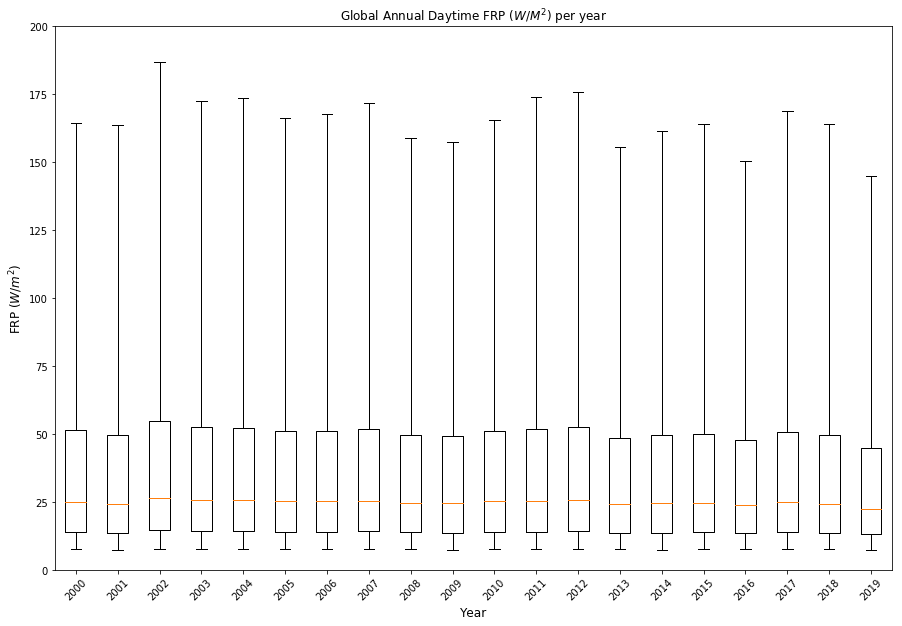

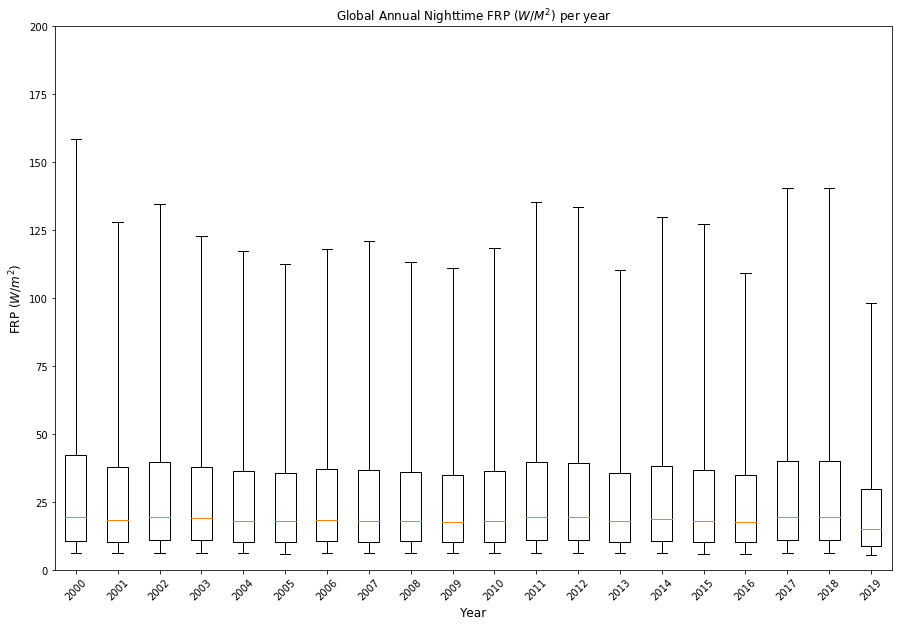

In [46]:
## day
percentiles = np.array([frp_day_5, frp_day_25, frp_day_median, frp_day_75, frp_day_95]).T
print(percentiles.shape)

fig, ax = plt.subplots(figsize=(15,10))
b = customized_box_plot(percentiles, ax, redraw=True, notch=0, sym='+', vert=1, whis=1.5)
ax.set_ylabel('FRP ($W/m^2$)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.set_title('Global Annual Daytime FRP ($W/M^2$) per year')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [str(v) for v in year]
ax.set_xticklabels(labels, rotation=45)
plt.show()

## night
percentiles = np.array([frp_night_5, frp_night_25, frp_night_median, frp_night_75, frp_night_95]).T
fig, ax = plt.subplots(figsize=(15,10))
b = customized_box_plot(percentiles, ax, redraw=True, notch=0, sym='+', vert=1, whis=1.5)
ax.set_ylabel('FRP ($W/m^2$)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.set_title('Global Annual Nighttime FRP ($W/M^2$) per year')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [str(v) for v in year]
ax.set_xticklabels(labels, rotation=45)

plt.show()

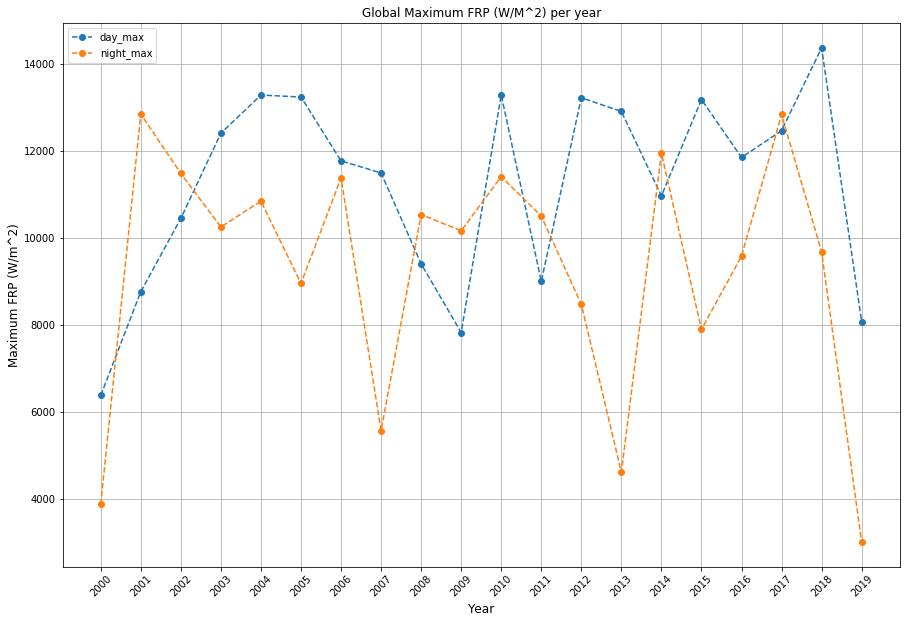

In [38]:
plt.figure(figsize=(15,10))
plt.plot(year,frp_day_max, '--o', label='day_max')
plt.plot(year,frp_night_max, '--o', label='night_max')
plt.grid()
plt.legend()
plt.ylabel('Maximum FRP (W/m^2)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Global Maximum FRP (W/M^2) per year')
plt.xticks(year, rotation=45);

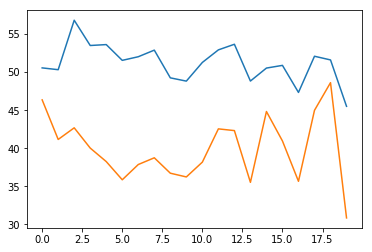

In [9]:
plt.plot(frp_day_mean)
plt.plot(frp_night_mean)

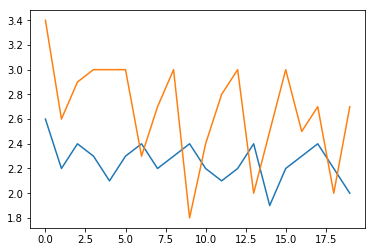

In [10]:
plt.plot(frp_day_min)
plt.plot(frp_night_min)

In [29]:
from matplotlib import pyplot as plt

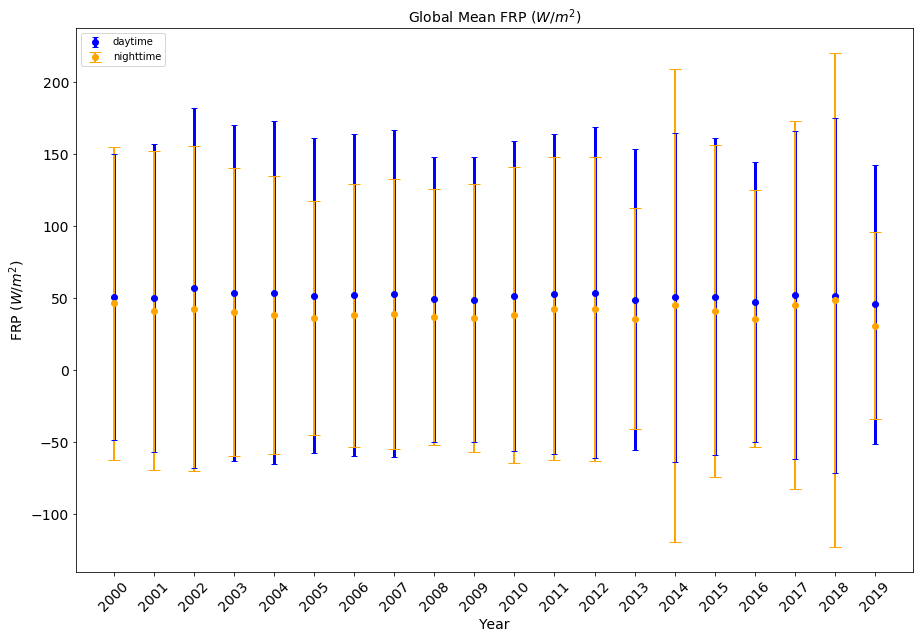

In [97]:
plt.figure(figsize=(15,10))
plt.errorbar(year, frp_day_mean, frp_day_std, fmt='ob', capsize=3, lw=3, label='daytime')
plt.errorbar(year, frp_night_mean, np.array(frp_night_std), 
             fmt='o', color='#FFA500', ecolor='#FFA500', lw=2, capsize=6, label='nighttime')
plt.xticks(year, fontsize=14, rotation=45);
plt.yticks(fontsize=14)
plt.ylabel(r'FRP ($W/m^2$)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title(r'Global Mean FRP ($W/m^2$)',fontsize=14)
plt.legend(fontsize=12)
plt.legend();

# plt.errorbar(np.arange(8), means, std, fmt='ok', lw=3)
# plt.errorbar(np.arange(8), means, [means - mins, maxes - means],
#              fmt='.k', ecolor='gray', lw=1)

In [36]:
frp_df = pd.DataFrame({'year':sorted(year),
                      'day_mean': frp_day_mean,
                      'day_std': frp_day_std,
                      'day_min': frp_day_min,
                       'day_max': frp_day_max,
                      'night_mean': frp_night_mean,
                      'night_std': frp_night_std,
                      'night_min':frp_night_min,
                      'night_max':frp_night_max})

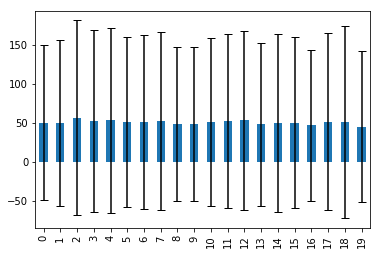

In [37]:
frp_df.day_mean.plot.bar(x=frp_df.year, yerr=frp_df.day_std, capsize=4)

#means.plot.bar(yerr=errors, ax=ax, capsize=4)

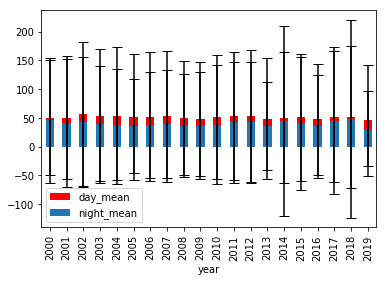

In [38]:
ax = frp_df.plot(kind='bar', x='year', y='day_mean', yerr='day_std', capsize=5, color='r')
ax = frp_df.plot(kind='bar', x='year', y='night_mean', yerr='night_std', capsize=5, ax=ax)

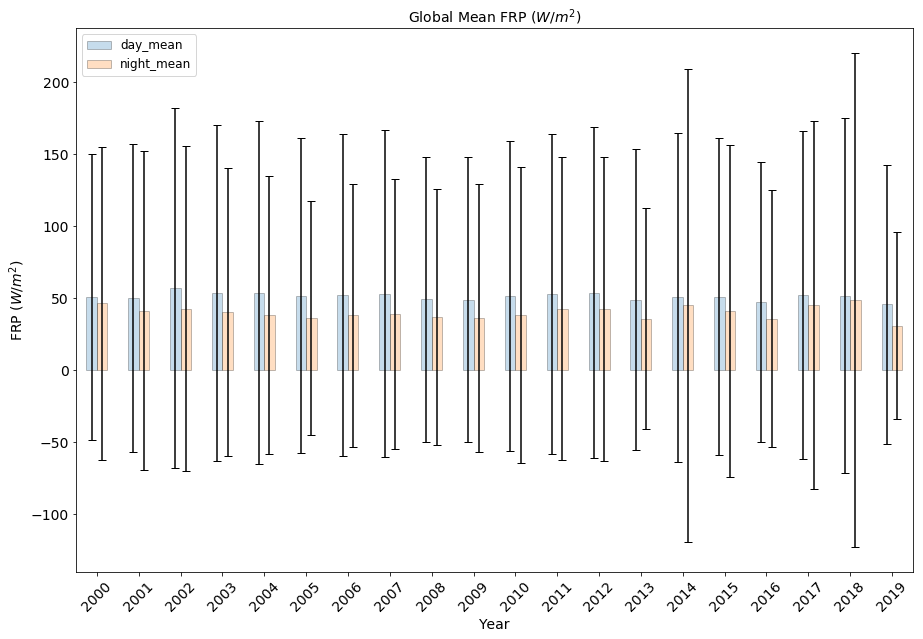

In [56]:
means = frp_df[['year', 'day_mean', 'night_mean']]
means.set_index('year', inplace=True)

maxes = frp_df[['year', 'day_max', 'night_max']]
maxes.set_index('year', inplace=True)

mins = frp_df[['year', 'day_min', 'night_min']]
mins.set_index('year', inplace=True)


errors = frp_df[['year', 'day_std', 'night_std']]
errors.set_index('year', inplace=True)
errors = errors.rename(columns={'day_std':'day_mean', 
                        'night_std':'night_mean'})

#plot
fig, ax = plt.subplots()
means.plot.bar(yerr=errors, 
               capsize=4, figsize=(15,10), rot=45, fontsize=14, alpha=0.25, edgecolor='k', ax=ax)
plt.legend(fontsize=12)
plt.ylabel(r'FRP ($W/m^2$)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title(r'Global Mean FRP ($W/m^2$)',fontsize=14)
plt.legend(fontsize=12)
# plt.xticks(year);


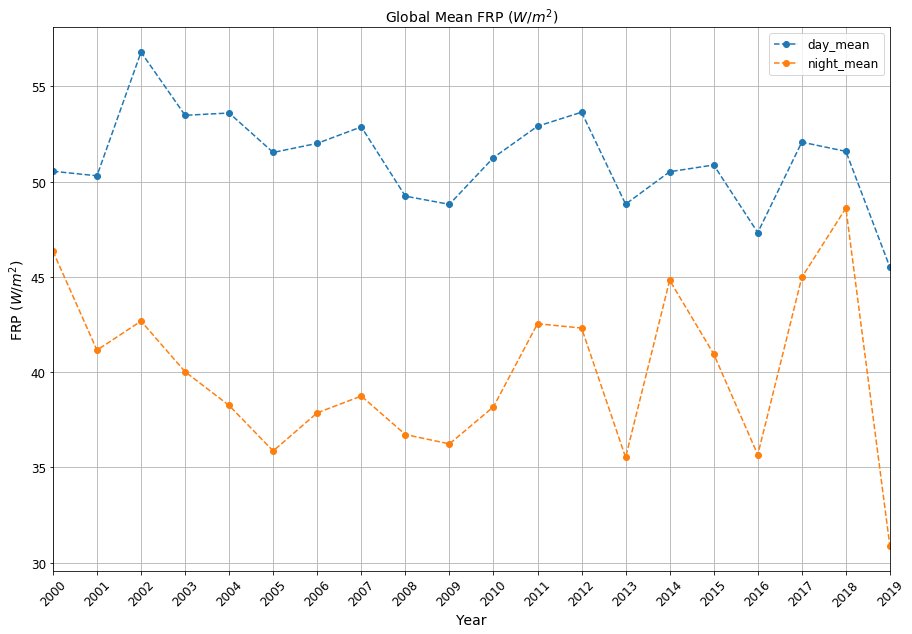

In [53]:
means.plot(kind='line', style='--o', figsize=(15,10), rot=45, fontsize=12, grid=True)
plt.ylabel(r'FRP ($W/m^2$)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title(r'Global Mean FRP ($W/m^2$)',fontsize=14)
plt.legend(fontsize=12)
plt.xticks(year);

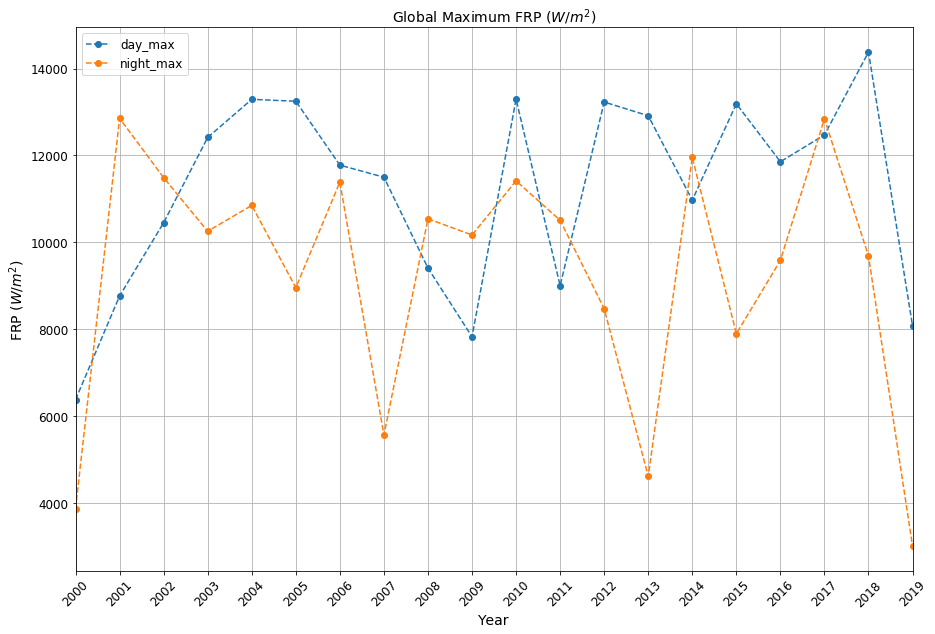

In [51]:
maxes.plot(kind='line', style='--o', figsize=(15,10), rot=45, fontsize=12, grid=True)
plt.ylabel(r'FRP ($W/m^2$)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title(r'Global Maximum FRP ($W/m^2$)',fontsize=14)
plt.legend(fontsize=12)
plt.xticks(year);

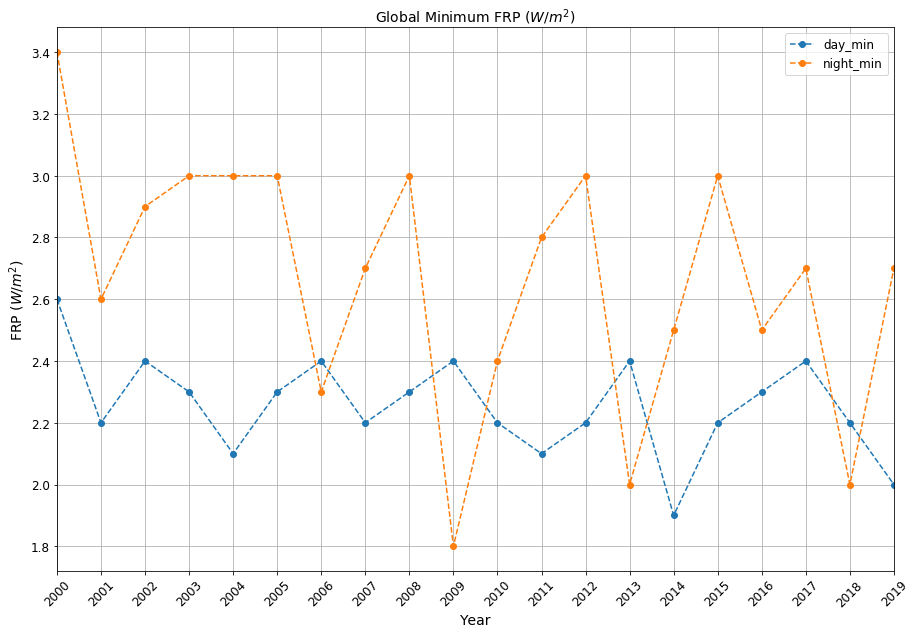

In [52]:
mins.plot(kind='line', style='--o', figsize=(15,10), rot=45, fontsize=12, grid=True)
plt.ylabel(r'FRP ($W/m^2$)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title(r'Global Minimum FRP ($W/m^2$)',fontsize=14)
plt.legend(fontsize=12)
plt.xticks(year);

In [66]:
mean_slopes = means.apply(lambda x: np.polyfit(means.index, x, 1)[0])
max_slopes = maxes.apply(lambda x: np.polyfit(maxes.index, x, 1)[0])
min_slopes = mins.apply(lambda x: np.polyfit(mins.index, x, 1)[0])
# np.polyfit(year, means.day_mean,1)

In [71]:
print(mean_slopes, '\n')
print(max_slopes, '\n')
print(min_slopes, '\n')

day_mean     -0.202307
night_mean   -0.044082
dtype: float64 

day_max      112.692406
night_max    -72.139774
dtype: float64 

day_min     -0.011053
night_min   -0.028647
dtype: float64 



In [77]:
## look at it for 2001 - 2018, to remove the incomplete years
means2 = means.iloc[1:-2]
mins2 = mins.iloc[1:-2]
maxes2 = maxes.iloc[1:-2]

mean_slopes2 = means2.apply(lambda x: np.polyfit(means2.index, x, 1)[0])
max_slopes2 = maxes2.apply(lambda x: np.polyfit(maxes2.index, x, 1)[0])
min_slopes2 = mins2.apply(lambda x: np.polyfit(mins2.index, x, 1)[0])

print('Slopes (2001-2018)')
print('***********************')
print(mean_slopes2, '\n')
print(max_slopes2, '\n')
print(min_slopes2, '\n')

Slopes (2001-2018)
***********************
day_mean     -0.213498
night_mean    0.100378
dtype: float64 

day_max      84.366912
night_max   -91.555147
dtype: float64 

day_min     -0.002941
night_min   -0.016667
dtype: float64 

